In [1]:
from google.colab import files
uploaded = files.upload()


Saving Product.csv to Product.csv
Saving Region.csv to Region.csv
Saving Reseller.csv to Reseller.csv
Saving Targets.csv to Targets.csv
Saving SalespersonRegion.csv to SalespersonRegion.csv
Saving Salesperson.csv to Salesperson.csv
Saving Sales.csv to Sales.csv


In [90]:
import pandas as pd
import sqlite3

# Reconnect to SQLite (this file is saved locally in Colab)
conn = sqlite3.connect('sales_project.db')

# List of your CSV files and their corresponding table names
files = {
    'Product.csv': 'Product',
    'Region.csv': 'Region',
    'Reseller.csv': 'Reseller',
    'Targets.csv': 'Targets',
    'SalespersonRegion.csv': 'SalespersonRegion',
    'Salesperson.csv': 'Salesperson',
    'Sales.csv': 'Sales'
}

In [106]:
# Define a helper function to clean currency-formatted columns
def clean_currency_columns(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)
    return df

# Reload all datasets with correct delimiter
product_df = pd.read_csv('Product.csv', delimiter='\t')
region_df = pd.read_csv('Region.csv', delimiter='\t')
reseller_df = pd.read_csv('Reseller.csv', delimiter='\t')
targets_df = pd.read_csv('Targets.csv', delimiter='\t')
salesperson_region_df = pd.read_csv('SalespersonRegion.csv', delimiter='\t')
salesperson_df = pd.read_csv('Salesperson.csv', delimiter='\t')
sales_df = pd.read_csv('Sales.csv', delimiter='\t')

# Convert OrderDate to datetime
sales_df['OrderDate'] = pd.to_datetime(sales_df['OrderDate'], errors='coerce')


# Clean currency fields where applicable
product_df = clean_currency_columns(product_df, ['Standard Cost'])
sales_df = clean_currency_columns(sales_df, ['Sales', 'Cost', 'Unit Price'])
targets_df['Target'] = targets_df['Target'].replace('[\$,]', '', regex=True).astype(float)

# Reload cleaned data into SQLite
product_df.to_sql('Product', conn, if_exists='replace', index=False)
region_df.to_sql('Region', conn, if_exists='replace', index=False)
reseller_df.to_sql('Reseller', conn, if_exists='replace', index=False)
targets_df.to_sql('Targets', conn, if_exists='replace', index=False)
salesperson_region_df.to_sql('SalespersonRegion', conn, if_exists='replace', index=False)
salesperson_df.to_sql('Salesperson', conn, if_exists='replace', index=False)
sales_df.to_sql('Sales', conn, if_exists='replace', index=False)

# Confirm reloading was successful by printing shape of each table
{
    "Product": product_df.shape,
    "Region": region_df.shape,
    "Reseller": reseller_df.shape,
    "Targets": targets_df.shape,
    "SalespersonRegion": salesperson_region_df.shape,
    "Salesperson": salesperson_df.shape,
    "Sales": sales_df.shape
}



{'Product': (397, 8),
 'Region': (10, 4),
 'Reseller': (701, 6),
 'Targets': (809, 3),
 'SalespersonRegion': (39, 2),
 'Salesperson': (18, 5),
 'Sales': (57851, 10)}

In [107]:
# Reload into SQLite
sales_df.to_sql('Sales', conn, if_exists='replace', index=False)

# Run the summary query again
query = '''
SELECT
  ROUND(SUM(Sales), 2) AS TotalSales,
  ROUND(SUM(Cost), 2) AS TotalCost,
  ROUND(SUM(Sales - Cost), 2) AS TotalProfit
FROM Sales;
'''

results_df = pd.read_sql(query, conn)
print(results_df)


   TotalSales    TotalCost  TotalProfit
0  77548570.2  76549075.63    999494.57


In [109]:
# Top-selling products by total sales amount

top_products_query = '''
SELECT
    P.Product,
    SUM(S.Quantity) AS UnitsSold,
    ROUND(SUM(S.Sales), 2) AS TotalSales
FROM Sales S
JOIN Product P ON S.ProductKey = P.ProductKey
GROUP BY P.Product
ORDER BY TotalSales DESC
LIMIT 10;
'''
top_products_df = pd.read_sql(top_products_query, conn)
print(top_products_df)


                   Product  UnitsSold  TotalSales
0   Mountain-200 Black, 38       2274  2944665.88
1   Mountain-200 Black, 42       1953  2517355.08
2  Mountain-200 Silver, 38       1714  2240091.34
3  Mountain-200 Silver, 42       1620  2108685.83
4  Mountain-200 Silver, 46       1567  2038938.83
5   Mountain-200 Black, 46       1424  1845368.54
6       Road-250 Black, 44       1332  1832750.05
7       Road-250 Black, 48       1152  1586672.94
8    Road-350-W Yellow, 48       1277  1283443.06
9    Touring-1000 Blue, 60        893  1263913.32


In [110]:
# Sales by region

region_sales_query = '''
SELECT
    R.Region,
    ROUND(SUM(S.Sales), 2) AS TotalSales
FROM Sales S
JOIN Region R ON S.SalesTerritoryKey = R.SalesTerritoryKey
GROUP BY R.Region
ORDER BY TotalSales DESC;
'''

region_sales_df = pd.read_sql(region_sales_query, conn)
print(region_sales_df)

           Region   TotalSales
0       Southwest  18001116.10
1          Canada  13875632.96
2       Northwest  12004822.45
3       Southeast   7638606.55
4         Central   7633386.86
5       Northeast   6715354.39
6          France   4527839.69
7  United Kingdom   3883042.96
8         Germany   1877743.39
9       Australia   1391024.85


In [111]:
# Salesperson performance

salesperson_query = '''
SELECT
    SP.Salesperson,
    ROUND(SUM(S.Sales), 2) AS TotalSales
FROM Sales S
JOIN Salesperson SP ON S.EmployeeKey = SP.EmployeeKey
GROUP BY SP.Salesperson
ORDER BY TotalSales DESC;
'''

salesperson_df = pd.read_sql(salesperson_query, conn)
print(salesperson_df)

                 Salesperson   TotalSales
0             Linda Mitchell  10158634.52
1             Jillian Carson   9755992.01
2             Michael Blythe   8952751.48
3                    Jae Pak   8099816.95
4                Tsvi Reiter   6976128.29
5                    Shu Ito   6283193.33
6               José Saraiva   5536439.26
7   Ranjit Varkey Chudukatil   4429368.45
8             David Campbell   3614760.61
9             Garrett Vargas   3486102.49
10       Pamela Ansman-Wolfe   3187720.14
11          Tete Mensa-Annan   2184211.15
12             Rachel Valdez   1681207.53
13             Lynn Tsoflias   1216916.52
14             Stephen Jiang   1073650.72
15               Amy Alberts    737568.42
16                Syed Abbas    174108.33


In [112]:
# Category-level insights

category_query = '''
SELECT
    Category,
    Subcategory,
    ROUND(SUM(Sales), 2) AS TotalSales
FROM Sales S
JOIN Product P ON S.ProductKey = P.ProductKey
GROUP BY Category, Subcategory
ORDER BY TotalSales DESC;
'''

category_df = pd.read_sql(category_query, conn)
print(category_df)

       Category        Subcategory   TotalSales
0         Bikes         Road Bikes  28681899.48
1         Bikes     Mountain Bikes  25880152.86
2         Bikes      Touring Bikes   9506980.82
3    Components    Mountain Frames   4493533.42
4    Components        Road Frames   3746817.13
5    Components     Touring Frames   1463309.26
6    Components             Wheels    679676.89
7      Clothing            Jerseys    549933.91
8      Clothing             Shorts    325297.09
9   Accessories            Helmets    250209.76
10     Clothing             Gloves    207372.85
11     Clothing              Vests    207249.38
12     Clothing             Tights    203041.16
13   Components          Cranksets    183123.06
14  Accessories         Bike Racks    182007.60
15     Clothing         Bib-Shorts    167171.79
16   Components         Handlebars    161990.56
17   Components             Pedals    133777.98
18   Components              Forks     77966.80
19   Components        Derailleurs     6

In [115]:
# Trends over time (monthly)

trend_query = '''
SELECT
    strftime('%Y-%m', OrderDate) AS Month,
    ROUND(SUM(Sales), 2) AS TotalSales
FROM Sales
GROUP BY Month
ORDER BY Month;
'''

trend_df = pd.read_sql(trend_query, conn)
print(trend_df)

      Month  TotalSales
0   2017-07   489328.40
1   2017-08  1540072.02
2   2017-09  1166332.45
3   2017-10   844832.71
4   2017-11  2325754.91
5   2017-12  1703435.09
6   2018-01   713229.54
7   2018-02  1900794.46
8   2018-03  1455280.27
9   2018-04   883010.98
10  2018-05  2269719.87
11  2018-06  1137251.90
12  2018-07  2411558.85
13  2018-08  3615914.46
14  2018-09  2894646.61
15  2018-10  1804176.93
16  2018-11  3054996.72
17  2018-12  2188205.66
18  2019-01  1318592.01
19  2019-02  2386073.19
20  2019-03  1564294.92
21  2019-04  1868433.35
22  2019-05  2882637.58
23  2019-06  1990249.25
24  2019-07  2729167.03
25  2019-08  4306549.14
26  2019-09  4153399.35
27  2019-10  2293200.43
28  2019-11  3490438.03
29  2019-12  3516971.30
30  2020-01  1664187.50
31  2020-02  2701954.05
32  2020-03  2741182.95
33  2020-04  2214090.83
34  2020-05  3328607.46


In [117]:
# Re-read salesperson.csv to refresh the variable
salesperson_df = pd.read_csv('Salesperson.csv', delimiter='\t')

# Re-merge the DataFrames
merged_df = sales_df.merge(product_df, on='ProductKey', how='left')
merged_df = merged_df.merge(region_df, on='SalesTerritoryKey', how='left')
merged_df = merged_df.merge(salesperson_df, on='EmployeeKey', how='left')



In [126]:
# Re-import necessary plotting and OS libraries
import matplotlib.pyplot as plt
import os

# Create a directory to store charts
os.makedirs("charts", exist_ok=True)

# Generate key aggregated insights
top_products = merged_df.groupby('Product')['Sales'].sum().sort_values(ascending=False).head(10)
sales_by_region = merged_df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
sales_by_salesperson = merged_df.groupby('Salesperson')['Sales'].sum().sort_values(ascending=False)
category_sales = merged_df.groupby(['Category', 'Subcategory'])['Sales'].sum().sort_values(ascending=False)
monthly_trends = merged_df.groupby(merged_df['OrderDate'].dt.to_period('M'))['Sales'].sum()

# Prepare for plotting
plots = {}

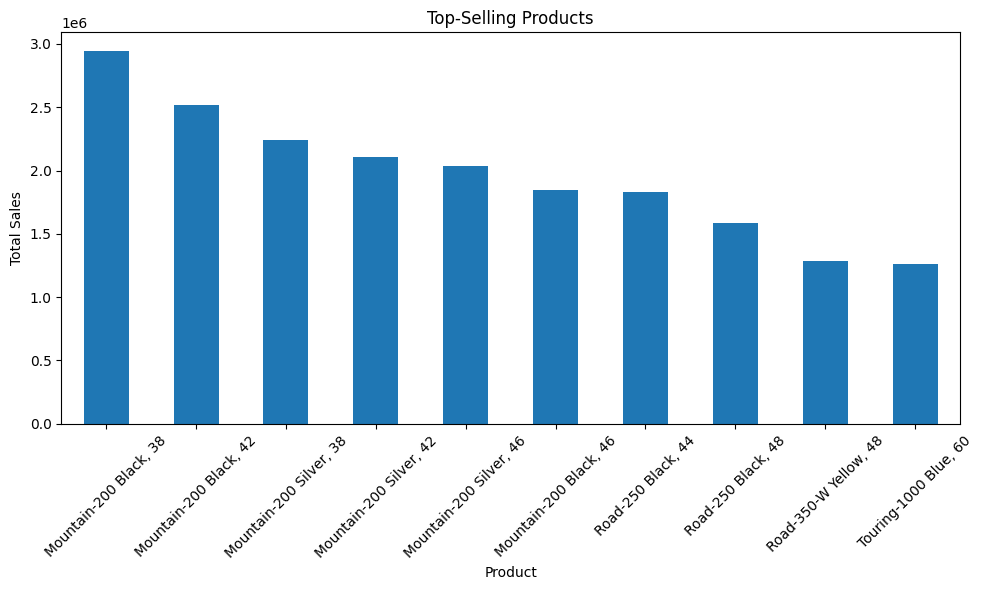

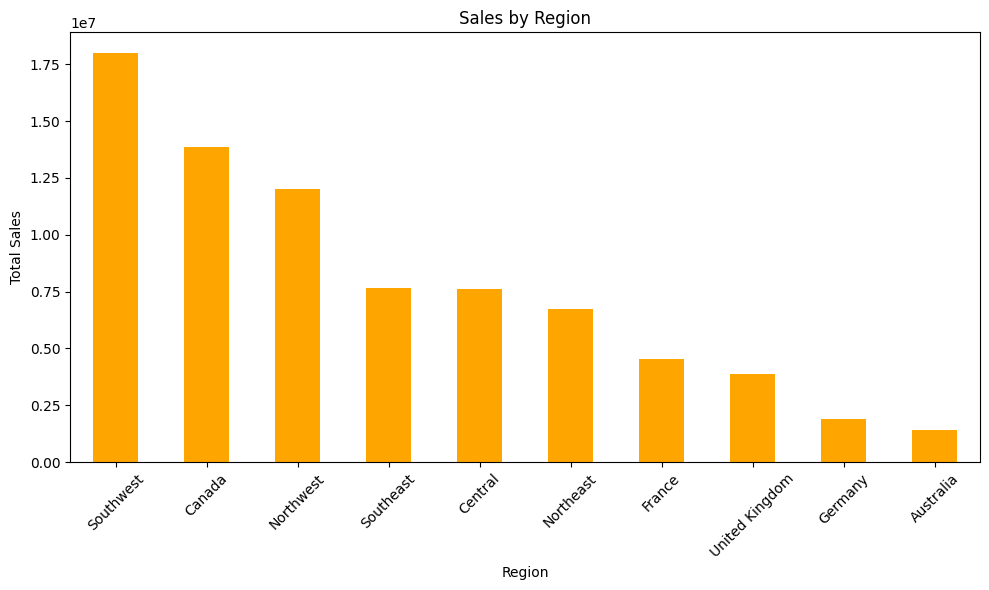

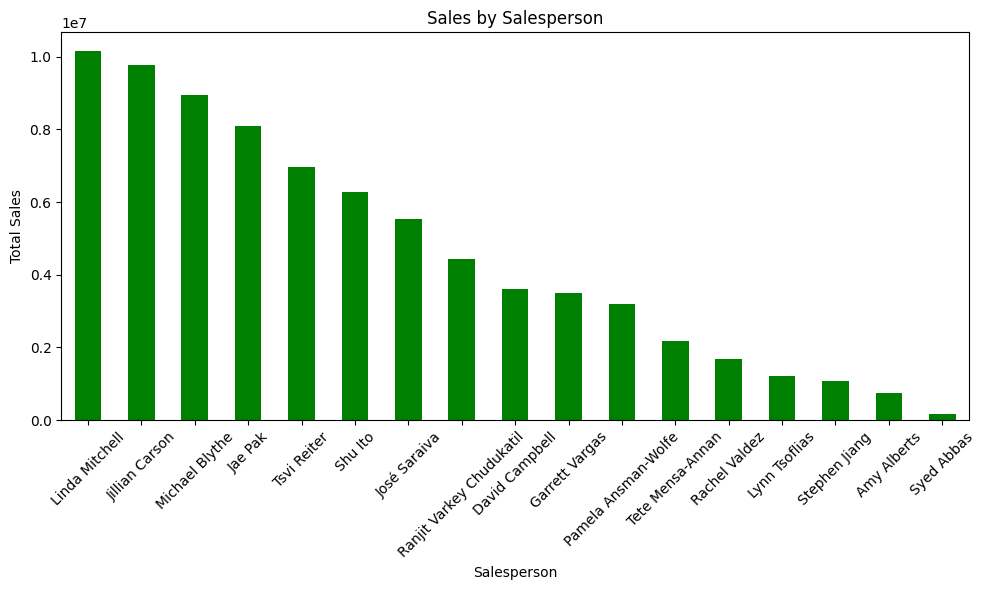

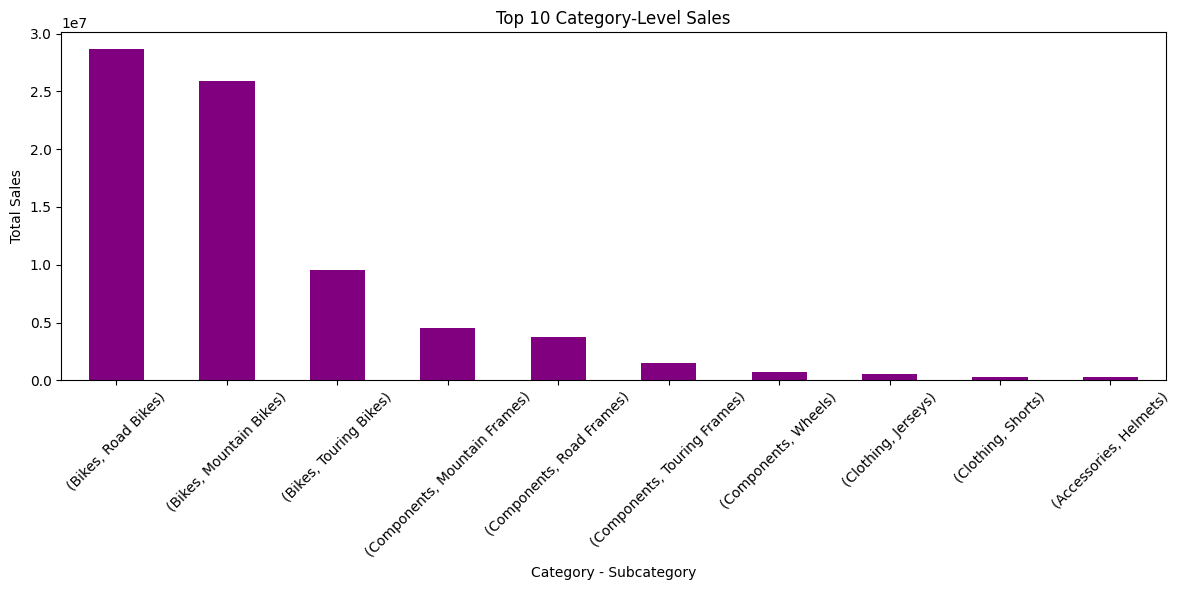

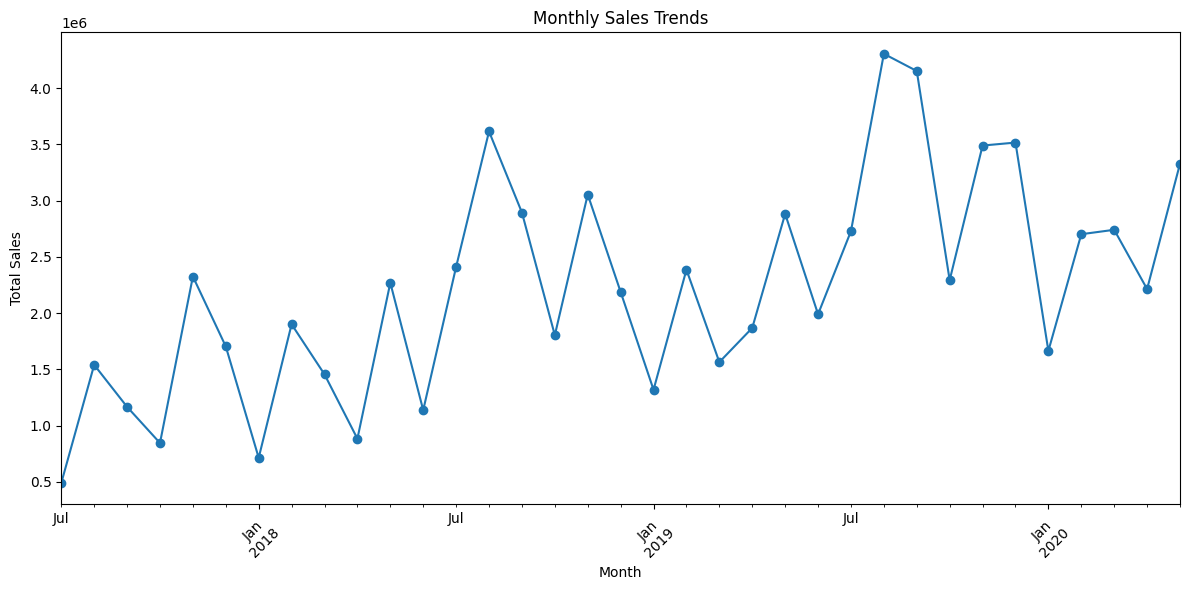

{'Top-Selling Products': 'charts/top_selling_products.png',
 'Sales by Region': 'charts/sales_by_region.png',
 'Sales by Salesperson': 'charts/sales_by_salesperson.png',
 'Category-Level Sales': 'charts/category_level_sales.png',
 'Monthly Sales Trends': 'charts/monthly_sales_trends.png'}

In [128]:
# Generate and save all charts
# 1. Top-Selling Products

plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title('Top-Selling Products')
plt.ylabel('Total Sales')
plt.xlabel('Product')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts/top_selling_products.png")
plt.show()  # 👈 This line displays the chart in Colab
plt.close()

# 2. Sales by Region
plt.figure(figsize=(10, 6))
sales_by_region.plot(kind='bar', color='orange')
plt.title('Sales by Region')
plt.ylabel('Total Sales')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts/sales_by_region.png")
plt.show()  # 👈 This line displays the chart in Colab
plt.close()

# 3. Sales by Salesperson
plt.figure(figsize=(10, 6))
sales_by_salesperson.plot(kind='bar', color='green')
plt.title('Sales by Salesperson')
plt.ylabel('Total Sales')
plt.xlabel('Salesperson')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts/sales_by_salesperson.png")
plt.show()  # 👈 This line displays the chart in Colab
plt.close()

# 4. Category-Level Sales
plt.figure(figsize=(12, 6))
category_sales.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Category-Level Sales')
plt.ylabel('Total Sales')
plt.xlabel('Category - Subcategory')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts/category_level_sales.png")
plt.show()  # 👈 This line displays the chart in Colab
plt.close()

# 5. Monthly Sales Trends
plt.figure(figsize=(12, 6))
monthly_trends.plot(kind='line', marker='o')
plt.title('Monthly Sales Trends')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("charts/monthly_sales_trends.png")
plt.show()  # 👈 This line displays the chart in Colab
plt.close()

# Confirm saved chart paths
saved_charts = {
    "Top-Selling Products": "charts/top_selling_products.png",
    "Sales by Region": "charts/sales_by_region.png",
    "Sales by Salesperson": "charts/sales_by_salesperson.png",
    "Category-Level Sales": "charts/category_level_sales.png",
    "Monthly Sales Trends": "charts/monthly_sales_trends.png"
}

saved_charts
